okay we will actually need to retrieve slope, intercept and window information from our metadata, apply these on our images, then normalize the image bring it to 0-225 scale and then feed into a CNN. Also, we will need to save it in a JPEG.

In [3]:
import pydicom as dicom
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import pandas as pd

# Preprocessing

In [2]:
## Example ##

data_path = "/home/sebastian/code/ipl1988/raw_data"
sample = dicom.dcmread(os.path.join(data_path, "stage_2_train", "ID_468a4348d.dcm"))

## Convert raw Pixels to Hounsefield Units

In [3]:
## !! The Images may already be in Hounsefield unit, indicated by 0 for intercept and slope?

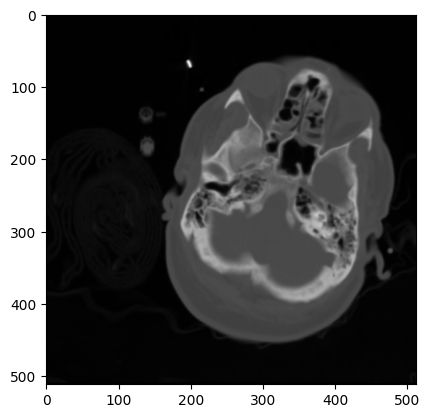

In [4]:
plt.imshow(sample.pixel_array, cmap='grey')

In [5]:
def transform_in_hu(img):
    slope = img.RescaleSlope
    intercept = img.RescaleIntercept
    img = img.pixel_array * slope + intercept
    return img

In [6]:
sample.pixel_array

array([[ 22,  25,  24, ...,  24,  24,  23],
       [ 22,  24,  24, ...,  24,  25,  24],
       [ 21,  22,  24, ...,  25,  23,  21],
       ...,
       [141, 135, 128, ...,  78,  84, 106],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [7]:
transformed_sample = transform_in_hu(sample)

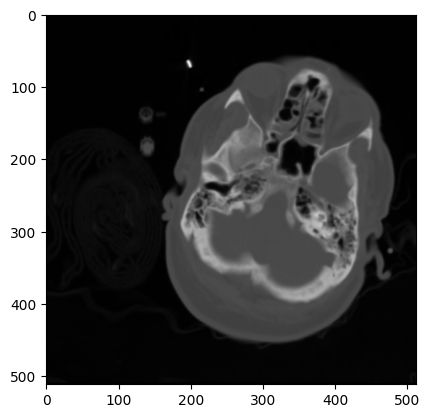

In [8]:
plt.imshow(transformed_sample, cmap='grey')

## Apply Windowing

In [10]:
windowed_transformed_sample = apply_window(transformed_sample, sample.WindowCenter, sample.WindowWidth)

NameError: name 'apply_window' is not defined

In [ ]:
plt.imshow(windowed_transformed_sample, cmap = 'grey')

In [ ]:
plt.imshow(normalizer(transformed_sample), cmap = 'grey')

In [ ]:
# Window Settings (unique to the image)
window_center = sample.WindowCenter
window_width = sample.WindowWidth

# Calculate the lower and upper bounds for the window
lower_bound = window_center - (window_width / 2)
upper_bound = window_center + (window_width / 2)

# Apply windowing by clipping to the bounds
windowed_array = np.clip(sample.pixel_array, lower_bound, upper_bound)

In [ ]:
def apply_window(img, window_center, window_width):
    
    # If the field is a MultiValue, extract the first element
    if isinstance(window_center, dicom.multival.MultiValue):
        window_center = window_center[0]
    if isinstance(window_width, dicom.multival.MultiValue):
        window_width = window_width[0]
    
    lower_bound = window_center - (window_width / 2)
    upper_bound = window_center + (window_width / 2)
    img = np.clip(img, lower_bound, upper_bound)
    return img

In [ ]:
windowed_array.max()

## Normalize the windowed image to the range [0, 1]


In [ ]:
def normalizer(img):
    minimum = np.min(img)
    maximum = np.max(img)
    img = ((img - minimum ) / (maximum - minimum))
    return img

In [ ]:
### Note: We may want to apply a different window depending on the present hemorrhage ###
## But this may be a thing to improve our model later. For now, it may be good to proceed with the subdural window

Recommended Window Settings
Subdural Window:

WL: 50, WW: 130
Balances visibility across various hemorrhages, including subdural, intraparenchymal, and intraventricular types, by enhancing hyperdense features.
Brain Window:

WL: 40, WW: 80
Provides better visualization for gray and white matter, which is useful for detecting subtle changes around subarachnoid hemorrhages.

If you must choose one single window for hemorrhage detection across all types:

**Use the Subdural Window (WL=50, WW=130) as it covers a broader range of densities typical for hemorrhages.**

# Trying to expand the logic to all the files in the folder

In [ ]:
image_path = os.path.join(os.getcwd(), "raw_data", "stage_2_train","ID_e73020990.dcm")
sample = dicom.dcmread(image_path)
plt.imshow(sample.pixel_array, cmap = 'grey');

In [ ]:
sample.pixel_array.shape

In [ ]:
import pydicom
import matplotlib.pyplot as plt
import os

# Define the path to the folder containing your DICOM files (relative to the working directory)
folder_path = os.path.join(os.getcwd(), "raw_data", "stage_2_train")
output_path = os.path.join(os.getcwd(), "processed_stage_2_train")

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Loop through each file in the directory, test the first 10 only!

img_array = []
k = 10 

for filename in os.listdir(folder_path)[0:k]:
    # Check if the file is a DICOM file (assuming .dcm extension)
    if filename.endswith('.dcm'):
        image_path = os.path.join(folder_path, filename)  # Full file path
        img = pydicom.dcmread(image_path)  # Read the DICOM file

    # store temp information needed for the window function
    window_center = img.WindowCenter
    window_width = img.WindowWidth
    
    ## apply HU transformation, returns transformed img
    img = transform_in_hu(img)

    ## apply unique window, returns windowed img
    img = apply_window(img, window_center, window_width)
    
    ## apply normalization, returns min-max-scaled image
    img = normalizer(img) * 255
    img = img.astype(np.uint8)  # Convert to 8-bit unsigned integer

    # Append the processed image to the array
    img_array.append(img)

    # Save as PNG
    output_file = os.path.join(output_path, filename.replace('.dcm', '.png'))
    img_pil = Image.fromarray(img)
    img_pil.save(output_file)

final_array = np.array(img_array)

In [ ]:
final_array.shape

# Taking Care of the Target values

## Load target data

In [1]:
data_path = "/home/sebastian/code/ipl1988/raw_data/"

In [4]:
import pandas as pd
import os 
df = pd.read_csv(os.path.join(data_path, "stage_2_train.csv"))

## Extract the Image ID
Assuming the ID column contains both the image ID (e.g., ID_12cadc6af) and the type of hemorrhage (e.g., epidural, intraparenchymal), we need to extract just the base ID. The base ID is the part before the first underscore. This can be done using the str.extract() method to grab everything up to the first underscore:

In [6]:
df['base_ID'] = df['ID'].str.extract(r'^(ID_[^_]+)')

## Group the Labels by the Base Image ID
Now, we can group the DataFrame by this base ID and collect all the corresponding Label values for each unique ID. We will use groupby() and apply(list) to create a list of labels for each image:

In [11]:
os.listdir("/home/sebastian/code/ipl1988/raw_data/stage_2_train_proc/images")

['ID_9dd4f16b7.png',
 'ID_ad3492f1f.png',
 'ID_7835d8bb8.png',
 'ID_a7c5141ad.png',
 'ID_0fa4fd0f4.png',
 'ID_b193fb36b.png',
 'ID_1de18a1eb.png',
 'ID_415c90b8a.png',
 'ID_8ba2db575.png',
 'ID_83f6ebecd.png',
 'ID_0e2bcdfe3.png',
 'ID_da7fe93ee.png',
 'ID_c4d772da0.png',
 'ID_8120e41cb.png',
 'ID_017d4bfa1.png',
 'ID_83cbc1147.png',
 'ID_f70acd088.png',
 'ID_da72a3b6a.png',
 'ID_e303f4d44.png',
 'ID_67c2c48a9.png',
 'ID_1b14c6107.png',
 'ID_453f50c77.png',
 'ID_cccc57e58.png',
 'ID_0cc66c5a5.png',
 'ID_6260b8ea6.png',
 'ID_dce02bd2a.png',
 'ID_50a5a2433.png',
 'ID_82a0c56e4.png',
 'ID_a44396bd1.png',
 'ID_9c4537895.png',
 'ID_5ba1ff365.png',
 'ID_f77854223.png',
 'ID_a19d4af14.png',
 'ID_d244afea9.png',
 'ID_455f96f48.png',
 'ID_ab45709c4.png',
 'ID_5684db3bf.png',
 'ID_6fc67cb7e.png',
 'ID_96a804092.png',
 'ID_66f6db905.png',
 'ID_baa6f8983.png',
 'ID_fc6103d78.png',
 'ID_210a1b750.png',
 'ID_f98bd724b.png',
 'ID_7e5e36f24.png',
 'ID_f7cfe0d3a.png',
 'ID_cd0d11ef8.png',
 'ID_43068327

In [19]:
grouped_data

{'ID_000012eaf': [0, 0, 0, 0, 0, 0],
 'ID_000039fa0': [0, 0, 0, 0, 0, 0],
 'ID_00005679d': [0, 0, 0, 0, 0, 0],
 'ID_00008ce3c': [0, 0, 0, 0, 0, 0],
 'ID_0000950d7': [0, 0, 0, 0, 0, 0],
 'ID_0000aee4b': [0, 0, 0, 0, 0, 0],
 'ID_0000ca2f6': [0, 0, 0, 0, 0, 0],
 'ID_0000f1657': [0, 0, 0, 0, 0, 0],
 'ID_000178e76': [0, 0, 0, 0, 0, 0],
 'ID_00019828f': [0, 0, 0, 0, 0, 0],
 'ID_0001dcc25': [0, 0, 0, 0, 0, 0],
 'ID_0001de0e8': [0, 0, 0, 0, 0, 0],
 'ID_0001f7f62': [0, 0, 0, 0, 0, 0],
 'ID_0002003a8': [0, 0, 0, 0, 0, 0],
 'ID_0002081b6': [0, 1, 0, 0, 0, 1],
 'ID_0002108bd': [0, 0, 0, 0, 0, 0],
 'ID_000229f2a': [0, 0, 0, 0, 0, 0],
 'ID_000230ed7': [0, 0, 0, 0, 0, 0],
 'ID_000259ccf': [0, 0, 0, 0, 0, 0],
 'ID_00025ef4b': [0, 0, 0, 0, 0, 0],
 'ID_000270f8b': [0, 0, 0, 0, 0, 0],
 'ID_00027c277': [0, 0, 0, 0, 0, 0],
 'ID_00027cbb1': [0, 0, 0, 0, 0, 0],
 'ID_000280440': [0, 0, 0, 0, 0, 0],
 'ID_0002a38ad': [0, 0, 0, 1, 1, 1],
 'ID_0002a616e': [0, 0, 0, 0, 0, 0],
 'ID_0002adc14': [0, 0, 0, 0, 0, 0],
 

In [7]:
grouped_data = df.groupby('base_ID')['Label'].apply(list).to_dict()

In [14]:
filter_images = os.listdir("/home/sebastian/code/ipl1988/raw_data/stage_2_train_proc/images")

In [27]:
filter_images_IDonly = [filename[:-4] for filename in filter_images]

In [29]:
# Filter the dictionary based on filter_images
filtered_data = {key: grouped_data[key] for key in filter_images_IDonly if key in grouped_data}

# Display the filtered dictionary
print(filtered_data)

{'ID_9dd4f16b7': [0, 0, 0, 0, 0, 0], 'ID_ad3492f1f': [0, 0, 0, 0, 0, 0], 'ID_7835d8bb8': [0, 0, 0, 0, 0, 0], 'ID_a7c5141ad': [0, 0, 0, 0, 0, 0], 'ID_0fa4fd0f4': [0, 0, 0, 0, 0, 0], 'ID_b193fb36b': [0, 0, 0, 0, 0, 0], 'ID_1de18a1eb': [0, 0, 0, 0, 0, 0], 'ID_415c90b8a': [0, 0, 0, 0, 0, 0], 'ID_8ba2db575': [0, 0, 0, 0, 0, 0], 'ID_83f6ebecd': [0, 0, 0, 0, 0, 0], 'ID_0e2bcdfe3': [0, 0, 0, 0, 0, 0], 'ID_da7fe93ee': [0, 0, 0, 0, 0, 0], 'ID_c4d772da0': [0, 0, 0, 0, 0, 0], 'ID_8120e41cb': [0, 0, 0, 0, 0, 0], 'ID_017d4bfa1': [0, 0, 0, 0, 0, 0], 'ID_83cbc1147': [0, 0, 0, 0, 0, 0], 'ID_f70acd088': [0, 0, 0, 0, 1, 1], 'ID_da72a3b6a': [0, 0, 0, 0, 0, 0], 'ID_e303f4d44': [0, 0, 0, 0, 0, 0], 'ID_67c2c48a9': [0, 1, 0, 0, 1, 1], 'ID_1b14c6107': [0, 1, 0, 0, 1, 1], 'ID_453f50c77': [0, 0, 0, 0, 0, 0], 'ID_cccc57e58': [0, 0, 0, 0, 0, 0], 'ID_0cc66c5a5': [0, 1, 0, 0, 0, 1], 'ID_6260b8ea6': [0, 0, 0, 0, 0, 0], 'ID_dce02bd2a': [0, 0, 0, 0, 0, 0], 'ID_50a5a2433': [0, 0, 0, 0, 0, 0], 'ID_82a0c56e4': [0, 0, 0, 0

In [31]:
df = pd.DataFrame(list(filtered_data.items()), columns=["Key", "Value"])

# Save to a CSV file
df.to_csv("training_data_labelled.csv", index=False)
print("Dictionary saved as CSV using Pandas.")

Dictionary saved as CSV using Pandas.


In [25]:
filter_images[0][:-4]

'ID_9dd4f16b7'

## Resulting Dictionary Structure
The resulting grouped_data will be a dictionary where the keys are the base image IDs and the values are lists of the labels corresponding to that image ID:

In [23]:
listi = ['ID_6784f8291.png', 'ID_3b890475a.png', 'ID_6721cf777.png', 'ID_ccb599d42.png', 'ID_7a96036b1.png', 'ID_62f94598f.png', 'ID_7982995c2.png', 'ID_56270d2e9.png', 'ID_d0985d8a7.png', 'ID_4cee84e7d.png', 'ID_5d7e2635c.png', 'ID_9ee993b17.png', 'ID_2052c1a39.png', 'ID_6040ae096.png', 'ID_9a599ae48.png', 'ID_c3c6e04cd.png', 'ID_9762c2689.png', 'ID_7ebda2fd6.png', 'ID_ff76e8c00.png', 'ID_e349c70eb.png', 'ID_9ee01b3b4.png', 'ID_638771420.png', 'ID_bbc93df55.png', 'ID_86578956e.png', 'ID_1af2dd287.png', 'ID_a8b0bfcf9.png', 'ID_2e30b1729.png', 'ID_73b2179ee.png', 'ID_5e5ceb72f.png', 'ID_23861c67d.png', 'ID_5267e8352.png', 'ID_7bacb0068.png', 'ID_dd0238591.png', 'ID_6c5751b78.png', 'ID_69fad3136.png', 'ID_24c07bfc9.png', 'ID_85264e5a9.png', 'ID_72c0efed4.png', 'ID_0cbe7d31c.png', 'ID_57137d3ac.png', 'ID_7bbcde720.png', 'ID_332db8504.png', 'ID_f80d8bc2f.png', 'ID_a987cf7e5.png', 'ID_e73020990.png', 'ID_eca95f32f.png', 'ID_88e2a718b.png', 'ID_b869bf6ec.png', 'ID_3df23fbad.png', 'ID_4d552bff2.png', 'ID_5904bd5c0.png', 'ID_0ca643a23.png', 'ID_85a3177f2.png', 'ID_ff71e0a97.png', 'ID_badad8143.png', 'ID_adb0484e3.png', 'ID_58b310b69.png', 'ID_f7e3572fc.png', 'ID_468a4348d.png', 'ID_7804a0d2f.png', 'ID_792c24856.png', 'ID_67abaedb3.png', 'ID_315e4a0af.png', 'ID_3dd887557.png', 'ID_dc2b5468f.png', 'ID_95882b995.png', 'ID_f9e571681.png', 'ID_65a1ef008.png', 'ID_8d4cb20d2.png', 'ID_9ff0a34d3.png', 'ID_da5b6c50e.png', 'ID_f6c35f050.png', 'ID_f4761321a.png', 'ID_3fcfeff47.png', 'ID_6092c3ee7.png', 'ID_b5cc80159.png', 'ID_e4737bd8f.png', 'ID_cf28fee99.png', 'ID_9065c48aa.png', 'ID_7b70733e3.png', 'ID_abc92f533.png', 'ID_c914c6b17.png', 'ID_f1f6a97ea.png', 'ID_012f2dfe2.png', 'ID_39e9c0cae.png', 'ID_d4e28a5f2.png', 'ID_570e30319.png', 'ID_2963804cd.png', 'ID_009e3bae5.png', 'ID_f12d1abab.png', 'ID_47fafa000.png', 'ID_7acba2209.png', 'ID_4bd198160.png', 'ID_4259e5dcc.png', 'ID_b50e6d82c.png', 'ID_dbd42eca5.png', 'ID_e30934cbd.png', 'ID_37a30a369.png', 'ID_df765399e.png', 'ID_3d03a698e.png']

In [30]:
temp = [grouped_data[file.split(".")[0]][-1] for file in listi]

In [31]:
test = [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
temp == test

True

### Extract the any_label for every ID ###

In [ ]:
raw_img_list = os.listdir("/home/sebastian/code/ipl1988/raw_data/stage_2_train")

In [ ]:
raw_img_list

In [ ]:
labels=[]

for filename in raw_img_list:
    value = grouped_data[filename[:-4]]
    labels.append(value[-1])

In [ ]:
tuple(labels)

### Cross-Check if the labels correspond correctly (examples)##

In [ ]:
# For File ID_85a3177f2 #

file_to_check = "ID_3d03a698e"

In [ ]:
# What index does this file have in the raw_img_list? #
index_no = raw_img_list.index(file_to_check + '.dcm')

In [ ]:
# What label is assigned to this index in the labels?#
labels[index_no]

In [ ]:
# Is the label equal to the label in the original df ? #
df[df['base_ID'] == file_to_check]